# compare different (Afro) GENIE samples with different models

In [1]:
import sys; sys.path.insert(0, '../../../'); 
from ccqe_notebook_tools import * 
from mupClassification_notebooks import *
from onbeam_offbeam_notebooks import *
from Xsec_tools import *
%matplotlib inline
sns.set(font_scale=2);sns.set_style("whitegrid");

versions:
{   'OffBeam': 'prod_reco_optfilter_extbnb_v12_mcc8_dev',
    'OnBeam': 'prod_reco_optfilter_bnb_v12_unblind_mcc8',
    'Overlay': 'prodgenie_bnb_nu_uboone_overlay_mcc8.11_reco2',
    'data date': '2018_05_11',
    'date': '2018_05_11',
    'overlay date': '2018_05_11'}
OffBeam_scaling: 0.706302660161 = N(on beam)/N(off beam) before SwT
f(POT): 0.0512441465374 = N(POT on beam)/N(POT MC)


## load genie

In [2]:
genie_dict = dict()
path = '/Users/erezcohen/Desktop/uBoone/CCQEanalysis/afro_genie_samples/'
for name in ['nominal','hA2015','hN2015','hA_SRC']:
    genie_dict[name] = pd.read_csv(path + 'CC_4_9E20_POT_mA_0_99'+'_'+name+'.csv')
    print 'loaded',name

loaded nominal
loaded hA2015
loaded hN2015
loaded hA_SRC


In [3]:
genie_CC1p_dict = dict()
for name in ['nominal','hA2015','hN2015','hA_SRC']:
    genie = genie_dict[name]
    genie_contained = genie[(genie.IsCC_1p_200MeVc==True)
                        & ((genie.v_x>3) & (genie.v_x<256))                        
                        & ((genie.v_y>-115) & (genie.v_y<115))                        
                        & ((genie.v_z>5) & (genie.v_z<1037))                        
                       ]
    genie_in_limits = sample_in_limits(sam=genie_contained
                                   ,varPmu='truth_Pmu',varPmu_cos_theta='truth_Pmu_cos_theta'
                                   ,varPp='truth_Pp',varPp_cos_theta='truth_Pp_cos_theta')
    genie_CC1p = genie_in_limits[genie_in_limits['IsCC_1p_200MeVc']==True]
    print len(genie_CC1p),'CC1p events in GENIE sample',name
    genie_CC1p_dict[name] = genie_CC1p

28848 CC1p events in GENIE sample nominal
29297 CC1p events in GENIE sample hA2015
17370 CC1p events in GENIE sample hN2015
26328 CC1p events in GENIE sample hA_SRC


## integreated cross-section

In [4]:
for name in ['nominal','hA2015','hN2015','hA_SRC']:
    genie_CC1p = genie_CC1p_dict[name]
    genie_integrated_Xsec,genie_integrated_Xsec_err = compute_Xsec(Non=len(genie_CC1p), Non_err=np.sqrt(len(genie_CC1p)))
    genie_integrated_Xsec,genie_integrated_Xsec_err = genie_integrated_Xsec*4.908e19/4.9e20,genie_integrated_Xsec_err*4.908e19/4.9e20
    print name,'genie Xsec: %.2f ± %.2f'%(genie_integrated_Xsec,genie_integrated_Xsec_err),'e-39 cm2'

nominal genie Xsec: 6.42 ± 0.04 e-39 cm2
hA2015 genie Xsec: 6.52 ± 0.04 e-39 cm2
hN2015 genie Xsec: 3.87 ± 0.03 e-39 cm2
hA_SRC genie Xsec: 5.86 ± 0.04 e-39 cm2


## single-differential cross-sections - $\mu$

In [87]:
def mystep(x,y,dx,y_width, ax=None, **kwargs):    
    for x_,y_,y_width_ in zip(x,y,y_width):
        plt.plot([x_-dx/2,x_+dx/2],[y_,y_] , **kwargs)

loaded single_differential_Xsec_Pmu_5_bins.csv
loaded single_differential_Xsec_Pmu_cos_theta_5_bins.csv
loaded single_differential_Xsec_Pmu_phi_5_bins.csv


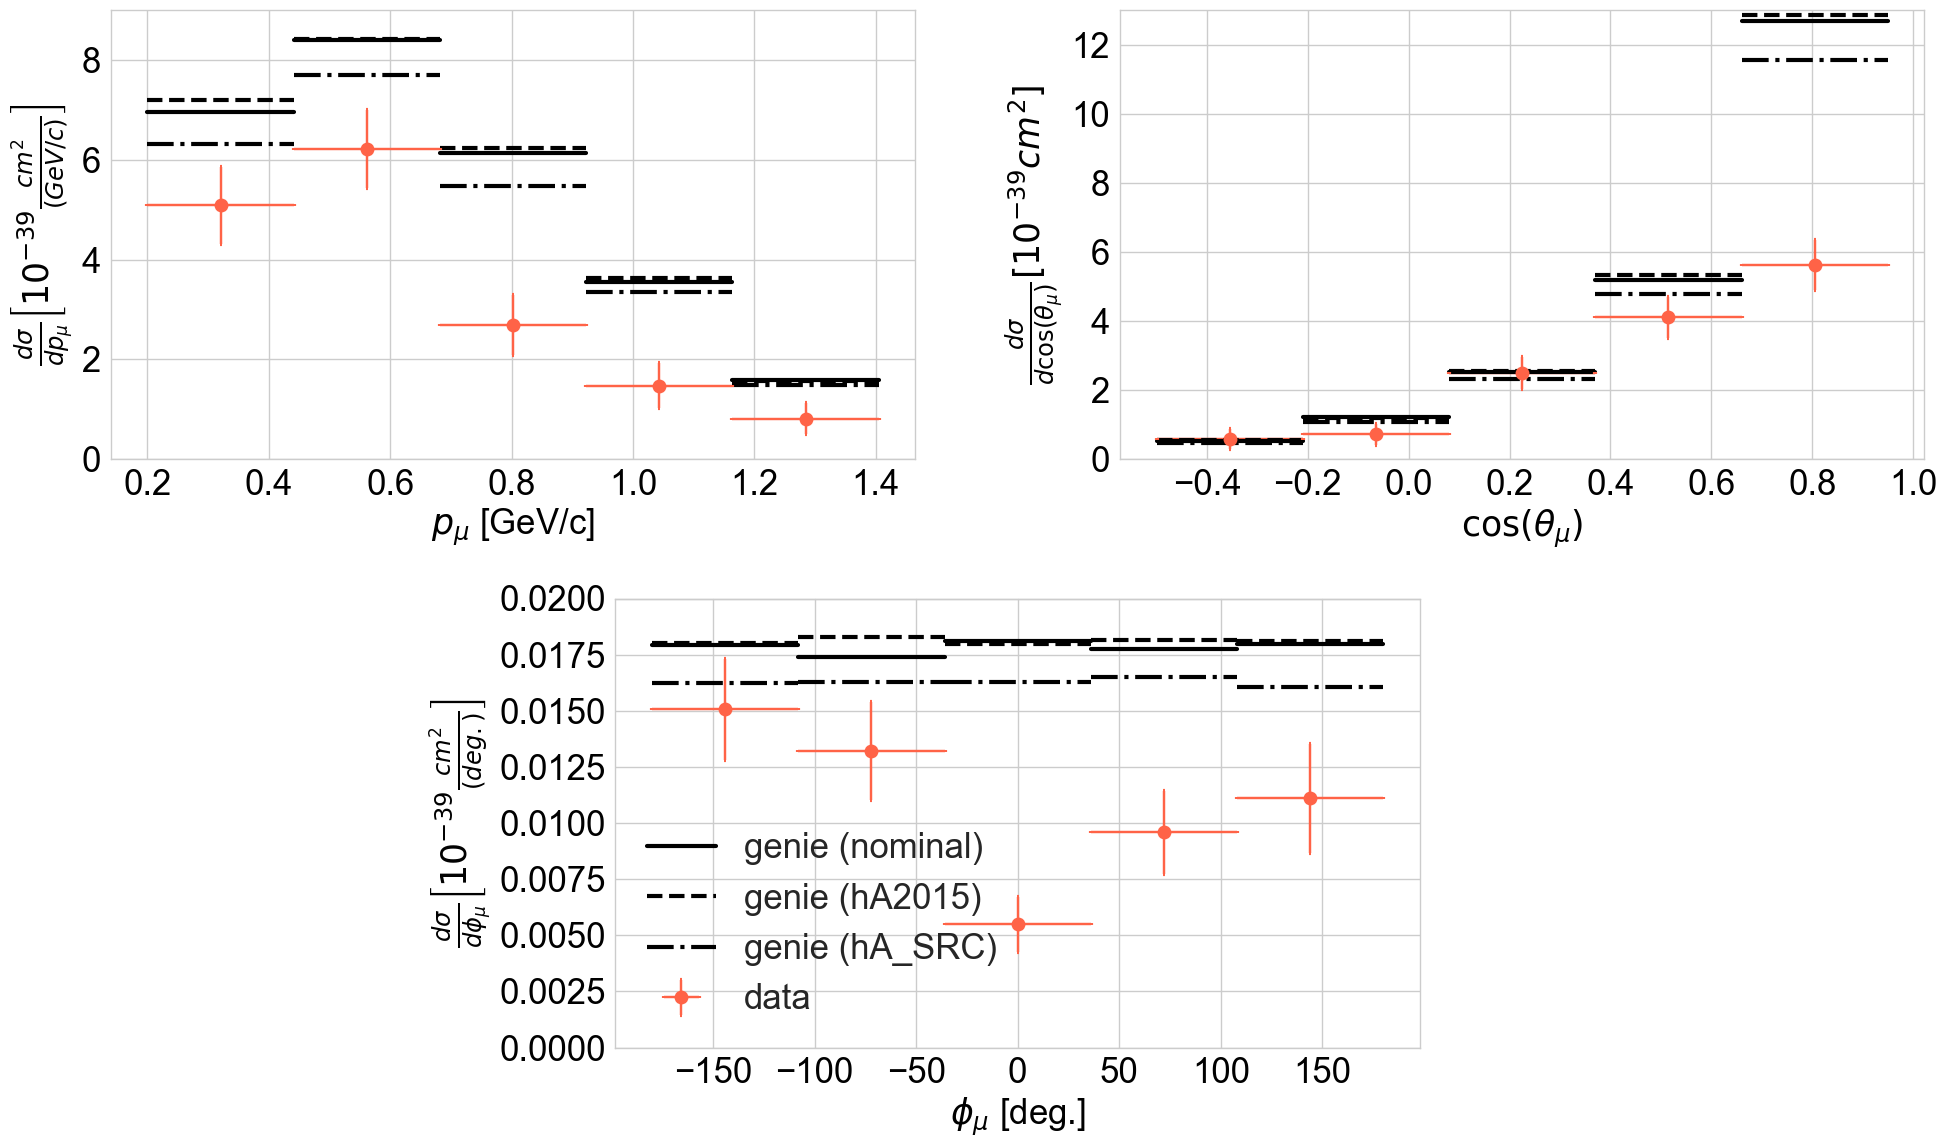

In [88]:
normalize=False
fig=plt.figure(figsize=(20,12))
for io,(observable,varname,ylim,mul,iax) in enumerate(zip(['Pmu','cos(theta(mu))','phi(mu)']
                                                          ,['Pmu','Pmu_cos_theta','Pmu_phi']
                                                          ,[(0,9),(0,13),(0,0.02)]                                                    
                                                          ,[1,1,180./np.pi]
                                                          ,[(1,2),(3,4),(6,7)])):
    bins,mid,bin_width,vlabel,xlabel,units = get_labels(observable=observable)
    name = 'single_differential_Xsec_'+varname+'_%d_bins'%(len(mid))
    Xsec_1d = np.loadtxt(Paths['1d Xsec'] + name + ".csv" , delimiter=",")
    Xsec_1d_err = np.loadtxt(Paths['1d Xsec'] + name + "_err.csv"  , delimiter=",")
    print 'loaded',name + ".csv"


    ax = fig.add_subplot(2,4,iax)
    for gname,ls in zip(['nominal','hA2015','hA_SRC']#,'hN2015'
                        ,['-','--','-.']):
        genie_CC1p = genie_CC1p_dict[gname]    
        h_genie,_ = np.histogram(mul*genie_CC1p['truth_'+varname],bins=bins)
        h_genie_err = np.sqrt(h_genie)
        h_genie,h_genie_err = h_genie*4.908e19/4.9e20, h_genie_err*4.908e19/4.9e20
        if normalize==True:
            h_genie,h_genie_err = h_genie/np.sum(h_genie), h_genie_err/np.sum(h_genie)

        genie_Xsec,genie_Xsec_err = np.zeros((len(bins)-1)), np.zeros((len(bins)-1))
        for i in range(len(bins)-1):
            genie_Xsec[i],genie_Xsec_err[i] = compute_Xsec(Non=h_genie[i], Non_err=h_genie_err[i] ,eff=1,eff_err=0,B=0, bin_width=bin_width )
        np.savetxt(Paths['1d Xsec'] + 'genie_' + gname + '_' + name + ".csv" , genie_Xsec , delimiter=",")
        np.savetxt(Paths['1d Xsec'] + 'genie_' + gname + '_' + name + "_err.csv" , genie_Xsec_err , delimiter=",")
        mystep(x=mid ,dx=bin_width, y=genie_Xsec, y_width=genie_Xsec_err, color='black',linestyle=ls,linewidth=3,label=r'genie ('+gname+')')
    ax.errorbar( x=mid , xerr=0.5*bin_width, y=Xsec_1d, yerr=Xsec_1d_err , fmt='o', markersize=10, color=Colors['beam on'], capsize=1, capthick=3, label='data')

        
    set_axes(ax,xlabel,y_label=(r'$\frac{d\sigma}{d'+vlabel+'}$' 
                                    +(r'$\left[10^{-39} \frac{cm^{2}}{(%s)}\right]$'%units if units is not None
                                     else r'$\left[10^{-39} cm^{2}\right]$'))                 
             ,do_add_legend=True if observable=='phi(mu)' else False
             ,ylim=ylim if normalize==False else None)
plt.tight_layout()

# proton cross-sections

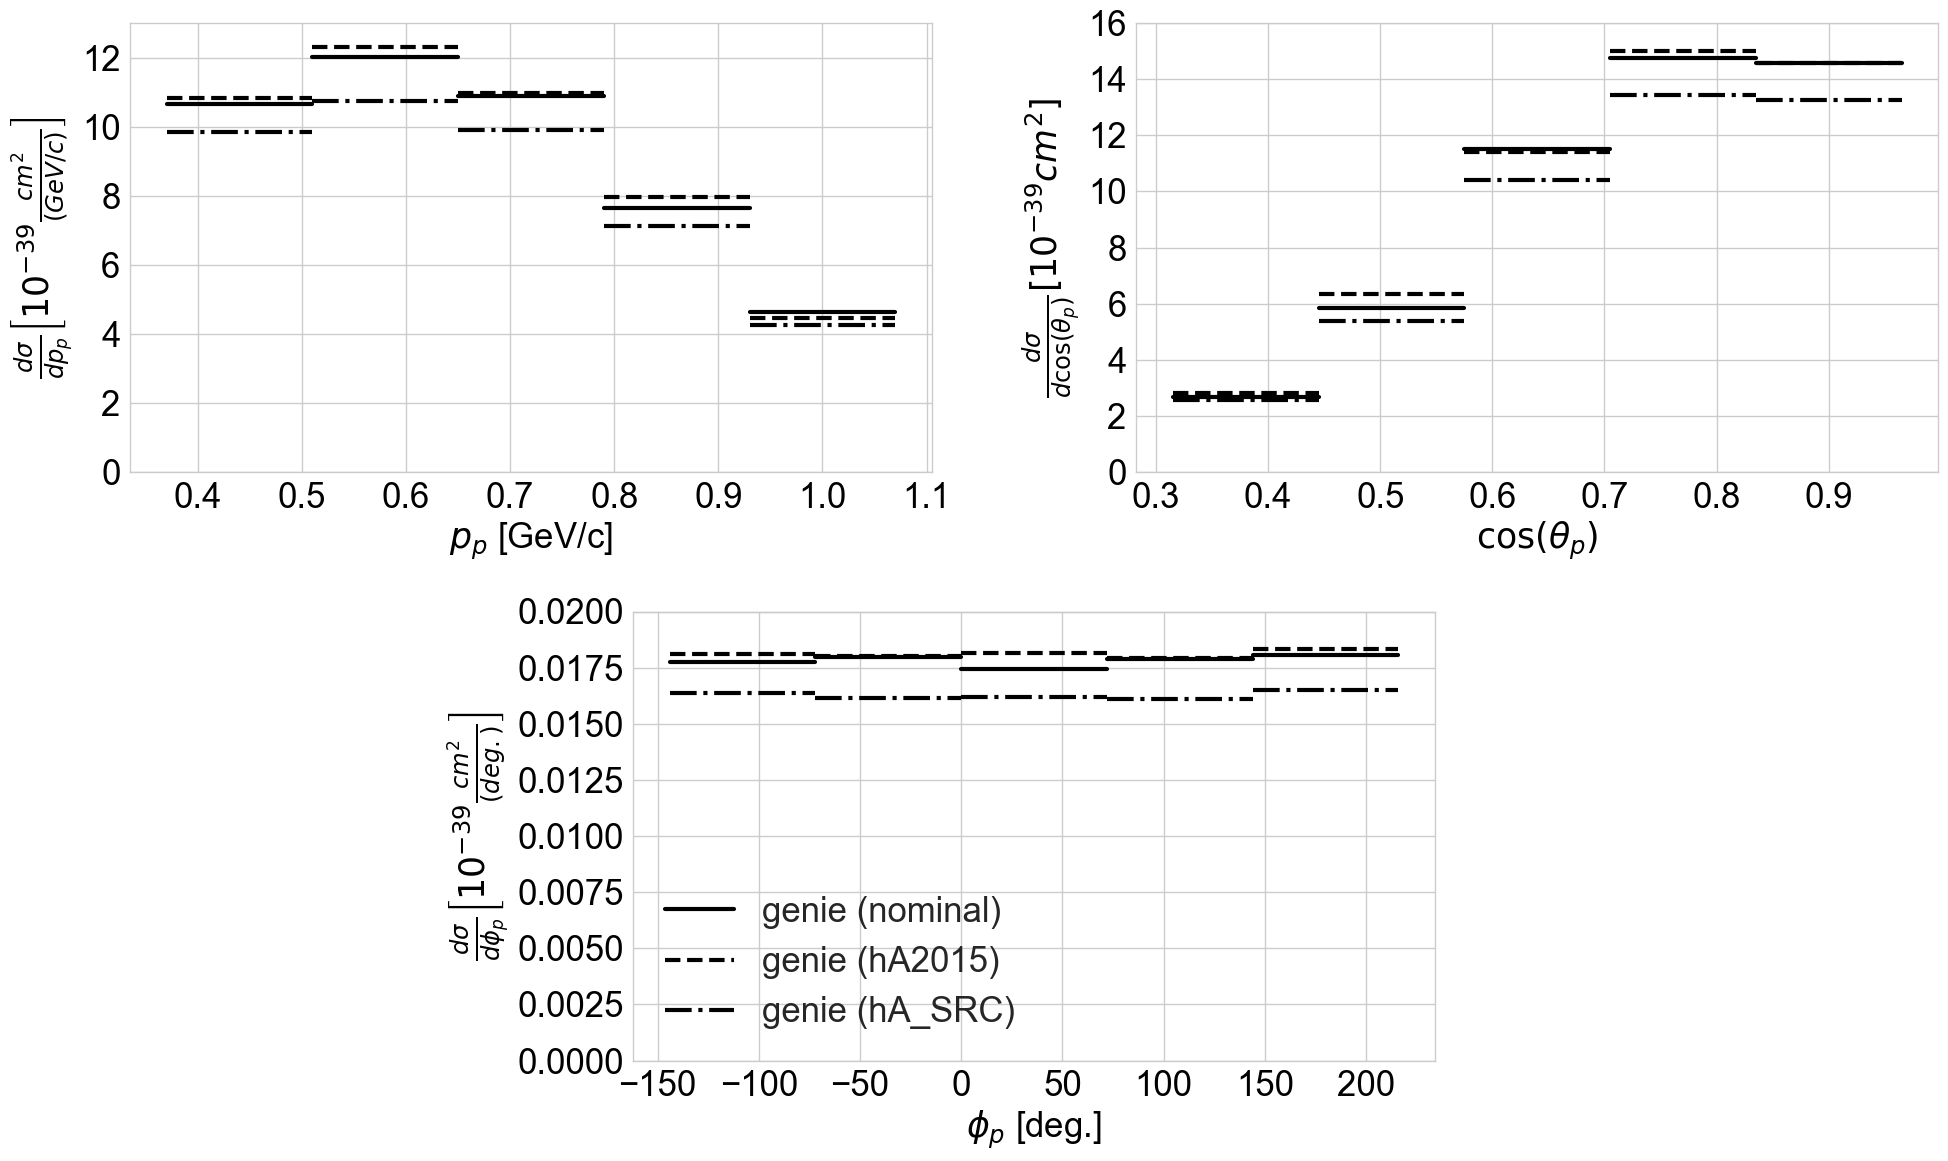

In [66]:
normalize=False

fig=plt.figure(figsize=(20,12))
for io,(observable,varname,ylim,mul,iax) in enumerate(zip(['Pp','cos(theta(p))','phi(p)']  
                                                      ,['Pp','Pp_cos_theta','Pp_phi']
                                                      ,[(0,13),(0,16),(0,0.02)]
                                                      ,[1,1,180./np.pi]
                                                          ,[(1,2),(3,4),(6,7)])):
    bins,mid,bin_width,vlabel,xlabel,units = get_labels(observable=observable)
    name = 'single_differential_Xsec_'+varname+'_%d_bins'%(len(mid))
    ax = fig.add_subplot(2,4,iax)
    for gname,ls in zip(['nominal','hA2015','hA_SRC']#,'hN2015'
                        ,['-','--','-.']):
        genie_CC1p = genie_CC1p_dict[gname]    
        h_genie,_ = np.histogram(mul*genie_CC1p['truth_'+varname],bins=bins)
        h_genie_err = np.sqrt(h_genie)
        h_genie,h_genie_err = h_genie*4.908e19/4.9e20, h_genie_err*4.908e19/4.9e20
        if normalize==True:
            h_genie,h_genie_err = h_genie/np.sum(h_genie), h_genie_err/np.sum(h_genie)

        genie_Xsec,genie_Xsec_err = np.zeros((len(bins)-1)), np.zeros((len(bins)-1))
        for i in range(len(bins)-1):
            genie_Xsec[i],genie_Xsec_err[i] = compute_Xsec(Non=h_genie[i], Non_err=h_genie_err[i] ,eff=1,eff_err=0,B=0, bin_width=bin_width )
        np.savetxt(Paths['1d Xsec'] + 'genie_' + gname + '_' + name + ".csv" , genie_Xsec , delimiter=",")
        np.savetxt(Paths['1d Xsec'] + 'genie_' + gname + '_' + name + "_err.csv" , genie_Xsec_err , delimiter=",")
#         print 'saved','genie_' + gname + '_' + name + ".csv"       
#         ax.bar( x=mid , height=2*genie_Xsec_err, bottom=genie_Xsec-genie_Xsec_err, width=bin_width, label=r'genie ('+gname+')')
        mystep(x=mid ,dx=bin_width, y=genie_Xsec, y_width=genie_Xsec_err, color='black',linestyle=ls,linewidth=3,label=r'genie ('+gname+')')

    set_axes(ax,xlabel,y_label=(r'$\frac{d\sigma}{d'+vlabel+'}$' 
                                    +(r'$\left[10^{-39} \frac{cm^{2}}{(%s)}\right]$'%units if units is not None
                                     else r'$\left[10^{-39} cm^{2}\right]$'))                 
             ,do_add_legend=True if observable=='phi(p)' else False
             ,ylim=ylim if normalize==False else None)

plt.tight_layout()